# DOA algorithm selection
Compares the performance of different DOA algorithms, via:

- Averaged angular error of source azimuth estimation.
- Minimum 2-source angular resolution.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound

Simulation parameters

In [3]:
# ROOM PARAMETERS
fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # room width
room_y = 20 # room length
stage_x = [1, 9]
stage_y = [13, 17] # x/y bounds of stage in the room
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air
source_step = 0.1 # resolution of simulation grid (m)

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption when order is nonzero

# MIC ARRAY PARAMETERS
pattern = pra.DirectivityPattern.CARDIOID
orientation = pra.DirectionVector(azimuth=90, colatitude=None, degrees=True)
directivity = pra.CardioidFamily(orientation=orientation, pattern_enum=pattern)

array_loc = [5, 11] # x/y location of array - front and center of stage
n_mics = 8 # number of microphones
sep = 0.1 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, fs, N) # uses omnidirectional mics by default
mic_array.set_directivity(directivities=directivity) # use cardioid microphones

# SOUND SOURCE PARAMETERS
source_x = np.arange(stage_x[0], stage_x[1]+source_step, source_step)
source_y = np.arange(stage_y[0], stage_y[1]+source_step, source_step) # Define spatial grid over which to simulate
source_filenames = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav']
_, singing = wavfile.read(source_filenames[0])
_, speech = wavfile.read(source_filenames[1])

### Run Simulations

1st test: single source placed on a grid over the stage.

Starting row at x = 1.0


/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_89031/1787596780.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors[i, j] = azimuth_error


Starting row at x = 1.1
Starting row at x = 1.2000000000000002
Starting row at x = 1.3000000000000003
Starting row at x = 1.4000000000000004
Starting row at x = 1.5000000000000004
Starting row at x = 1.6000000000000005
Starting row at x = 1.7000000000000006
Starting row at x = 1.8000000000000007
Starting row at x = 1.9000000000000008
Starting row at x = 2.000000000000001
Starting row at x = 2.100000000000001
Starting row at x = 2.200000000000001
Starting row at x = 2.300000000000001
Starting row at x = 2.4000000000000012
Starting row at x = 2.5000000000000013
Starting row at x = 2.6000000000000014
Starting row at x = 2.7000000000000015
Starting row at x = 2.8000000000000016
Starting row at x = 2.9000000000000017
Starting row at x = 3.0000000000000018
Starting row at x = 3.100000000000002
Starting row at x = 3.200000000000002
Starting row at x = 3.300000000000002
Starting row at x = 3.400000000000002
Starting row at x = 3.500000000000002
Starting row at x = 3.6000000000000023
Starting r

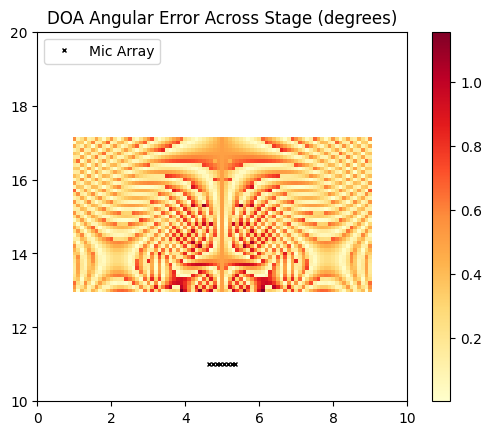

Average azimuth error across stage (deg):  0.33168727777962775
Maximum azimuth error across stage (deg):  1.1571624580569624
Minimum azimuth error across stage (deg):  0.0005089155219765826


In [15]:
errors = np.empty(shape=(len(source_x),len(source_y)))
doa_res = 180 # number of candiate angles provided to DOA algorithm - equally spaced between 0 and 180 degrees

for i in range(len(source_x)):
    print(f'Starting row at x = {source_x[i]}')
    for j in range(len(source_y)):

        x = source_x[i]
        y = source_y[j]

        # build room, array, and sources
        room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
        room.add_microphone_array(mic_array)

        s1 = [x, y] # 1st source location
        room.add_source(s1, signal=singing, delay=0)
        azimuth_gt = math.atan2(s1[1] - array_loc[1], s1[0] - array_loc[0]) # ground truth azimuth value

        # run simulation
        room.compute_rir()
        room.simulate()

        # define DOA algorithm and compute azimuth
        X = np.array(
            [
                pra.transform.stft.analysis(signal, N, N // 2).T
                for signal in room.mic_array.signals
            ]
        )

        doa = pra.doa.tops.TOPS(R, fs, N, c=v_sound, num_src=1, mode='far', azimuth=np.linspace(0, 180, doa_res)*np.pi/180)
        doa.locate_sources(X, freq_bins=np.arange(1, N))
        azimuth_doa = doa.azimuth_recon

        # compute and store azimuth error
        azimuth_error = abs(azimuth_gt - azimuth_doa)
        errors[i, j] = azimuth_error

errors = errors * 180.0/np.pi # convert errors to degrees

# plot error as a function of location
y, x = np.meshgrid(source_y, source_x)
error_min = np.min(errors)
error_max = np.max(errors)
error_avg = np.mean(errors)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, errors, cmap='YlOrRd', vmin=error_min, vmax=error_max)
ax.plot(mic_array.R[0], mic_array.R[1], 'kx', markersize=3, label="Mic Array")
ax.set_title('DOA Angular Error Across Stage (degrees)')
ax.axis([0, room_x, room_y/2, room_y])
fig.gca().set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax)
plt.legend(loc="upper left")
plt.show()

# output SIR stats
print("Average azimuth error across stage (deg): ", error_avg)
print("Maximum azimuth error across stage (deg): ", error_max)
print("Minimum azimuth error across stage (deg): ", error_min)

2nd test: identification of two separate sources placed increasingly close together, directly in front of the array

Separation: 2.00 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.99 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.98 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.97 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.96 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.95 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.94 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.93 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.92 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.91 m: DOAs: [ 76.42458101 103.57541899] deg
Separation: 1.90 m: DOAs: [ 76.42458101 102.5698324 ] deg
Separation: 1.89 m: DOAs: [ 77.4301676 102.5698324] deg
Separation: 1.88 m: DOAs: [ 77.4301676 102.5698324] deg
Separation: 1.87 m: DOAs: [ 77.4301676 102.5698324] deg
Separation: 1.86 m: DOAs: [ 77.4301676 102.5698324] deg
Separation: 1.85 m: DOAs: [ 77.4301676 102.5698324] deg
Separation: 1.84 m: DOAs: [ 77.4301676 102.5698324] deg
Separation: 1.83 m: DOAs: 

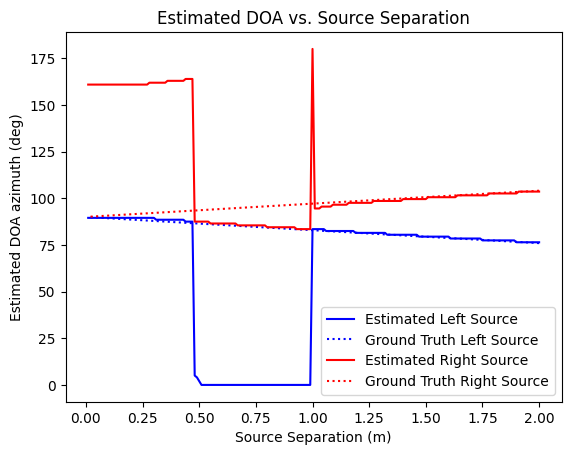

In [18]:
separations = np.arange(2, 0, -0.01)
doa_res = 180 # number of candiate angles provided to DOA algorithm - equally spaced between 0 and 180 degrees
doas = np.empty(shape=(len(separations), 2))
doas_gt = np.empty(shape=(len(separations), 2))

for i in range(len(separations)):

    # define sources at center stage
    sources_y = (stage_y[1] - stage_y[0])/2 + stage_y[0]
    s1_x = (stage_x[1] - stage_x[0])/2 + stage_x[0] + separations[i]/2
    s2_x = (stage_x[1] - stage_x[0])/2 + stage_x[0] - separations[i]/2

    # build room, array, and sources
    room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
    room.add_microphone_array(mic_array)

    s1 = [s1_x, sources_y] # 1st source location
    room.add_source(s1, signal=singing, delay=0)
    s2 = [s2_x, sources_y]
    room.add_source(s2, signal=speech, delay=0)

    azimuth1_gt = math.atan2(s1[1] - array_loc[1], s1[0] - array_loc[0]) # store ground truth azimuth values
    azimuth2_gt = math.atan2(s2[1] - array_loc[1], s2[0] - array_loc[0])
    doas_gt[i, :] = 180.0 / np.pi * np.array([azimuth1_gt, azimuth2_gt])

    # run simulation
    room.compute_rir()
    room.simulate()

    # define DOA algorithm and compute azimuth
    X = np.array(
        [
            pra.transform.stft.analysis(signal, N, N // 2).T
            for signal in room.mic_array.signals
        ]
    )

    doa = pra.doa.srp.SRP(R, fs, N, c=v_sound, num_src=2, mode='far', azimuth=np.linspace(0, 180, doa_res)*np.pi/180)
    doa.locate_sources(X, freq_bins=np.arange(1, N))
    azimuth_doa = doa.azimuth_recon
    azimuth_doa.sort()
    doas[i, :] = 180.0 / np.pi * azimuth_doa
    print(f'Separation: {separations[i]:.2f} m: DOAs: {azimuth_doa * 180.0/np.pi} deg')

# plot separation vs. estimated DOAs to see where algorithm breaks down.
fig, ax = plt.subplots()
ax.plot(separations, doas[:, 0], 'b-', label="Estimated Left Source")
ax.plot(separations, doas_gt[:, 0], 'b:', label="Ground Truth Left Source")
ax.plot(separations, doas[:, 1], 'r-', label="Estimated Right Source")
ax.plot(separations, doas_gt[:, 1], 'r:', label="Ground Truth Right Source")
ax.set_title('Estimated DOA vs. Source Separation')
plt.xlabel('Source Separation (m)')
plt.ylabel('Estimated DOA azimuth (deg)')
plt.legend(loc="lower right")
plt.show()

3rd test: avaliable sweep angle

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_92920/1089639082.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  doas[i] = 180.0 / np.pi * azimuth_doa


Sweep: 0.00 deg: DOA: [0.] deg
Sweep: 1.00 deg: DOA: [1.00558659] deg
Sweep: 2.00 deg: DOA: [2.01117318] deg
Sweep: 3.00 deg: DOA: [3.01675978] deg
Sweep: 4.00 deg: DOA: [4.02234637] deg
Sweep: 5.00 deg: DOA: [5.02793296] deg
Sweep: 6.00 deg: DOA: [6.03351955] deg
Sweep: 7.00 deg: DOA: [7.03910615] deg
Sweep: 8.00 deg: DOA: [8.04469274] deg
Sweep: 9.00 deg: DOA: [9.05027933] deg
Sweep: 10.00 deg: DOA: [10.05586592] deg
Sweep: 11.00 deg: DOA: [11.06145251] deg
Sweep: 12.00 deg: DOA: [12.06703911] deg
Sweep: 13.00 deg: DOA: [13.0726257] deg
Sweep: 14.00 deg: DOA: [14.07821229] deg
Sweep: 15.00 deg: DOA: [15.08379888] deg
Sweep: 16.00 deg: DOA: [16.08938547] deg
Sweep: 17.00 deg: DOA: [17.09497207] deg
Sweep: 18.00 deg: DOA: [18.10055866] deg
Sweep: 19.00 deg: DOA: [19.10614525] deg
Sweep: 20.00 deg: DOA: [20.11173184] deg


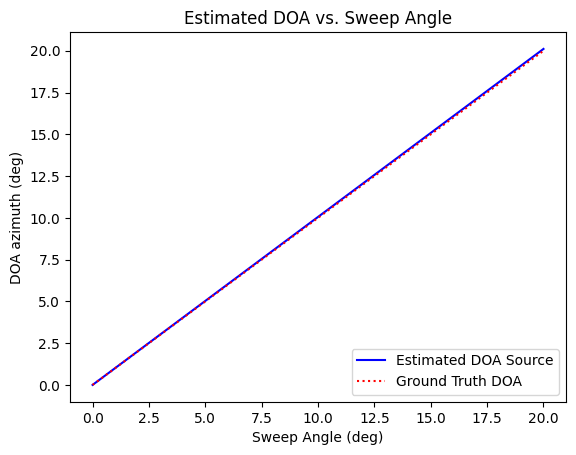

In [17]:
sweep = np.arange(0, 21, 1)*np.pi/180
doa_res = 180 # number of candiate angles provided to DOA algorithm - equally spaced between 0 and 180 degrees
doas = np.empty(shape=(len(sweep)))
doas_gt = np.empty(shape=(len(sweep)))

for i in range(len(sweep)):

    # define source at 3 metre distance from array
    s1_x = 3*np.cos(sweep[i]) +  array_loc[0]
    s1_y = 3*np.sin(sweep[i]) +  array_loc[1]

    # build room, array, and sources
    room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
    room.add_microphone_array(mic_array)

    s1 = [s1_x, s1_y] # 1st source location
    room.add_source(s1, signal=singing, delay=0)

    azimuth_gt = math.atan2(s1[1] - array_loc[1], s1[0] - array_loc[0]) # store ground truth azimuth values
    doas_gt[i] = 180.0 / np.pi * np.array(azimuth_gt)

    # run simulation
    room.compute_rir()
    room.simulate()

    # define DOA algorithm and compute azimuth
    X = np.array(
        [
            pra.transform.stft.analysis(signal, N, N // 2).T
            for signal in room.mic_array.signals
        ]
    )

    doa = pra.doa.normmusic.NormMUSIC(R, fs, N, c=v_sound, num_src=1, mode='far', azimuth=np.linspace(0, 180, doa_res)*np.pi/180)
    doa.locate_sources(X, freq_bins=np.arange(1, N))
    azimuth_doa = doa.azimuth_recon
    doas[i] = 180.0 / np.pi * azimuth_doa
    print(f'Sweep: {sweep[i] * 180.0/np.pi:.2f} deg: DOA: {azimuth_doa * 180.0/np.pi} deg')

# plot sweep vs. error to see where algorithm breaks down.
fig, ax = plt.subplots()
ax.plot(sweep*180.0/np.pi, doas, 'b-', label="Estimated DOA Source")
ax.plot(sweep*180.0/np.pi, doas_gt, 'r:', label="Ground Truth DOA")
ax.set_title('Estimated DOA vs. Sweep Angle')
plt.xlabel('Sweep Angle (deg)')
plt.ylabel('DOA azimuth (deg)')
plt.legend(loc="lower right")
plt.show()